# Modelado de Efectividad - CS:GO Dataset

**Objetivo:** Entrenar modelos de clasificación para predecir nivel de efectividad del jugador en CS:GO basado en EffectivenessScore

**Target Principal:** EffectivenessLevel (Bajo, Medio, Alto)

**Features Principales:** RoundHeadshots, GrenadeEffectiveness

**Metodología:** Comparación de algoritmos con GridSearchCV, análisis de curvas de aprendizaje y visualizaciones avanzadas

---

## 1. Importación de Librerías

In [2]:
# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn para ML
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score, 
    StratifiedKFold, learning_curve, validation_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_auc_score, 
    roc_curve, precision_recall_curve, auc
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)

print("Librerías importadas exitosamente")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

Librerías importadas exitosamente
Pandas version: 2.2.3
Numpy version: 2.2.6
Scikit-learn version: 1.6.1


## 2. Carga y Exploración de Datos

In [3]:
# Cargar dataset
try:
    df = pd.read_csv("../data/04_feature/csgo_data_with_features.csv")
    print(f"Dataset con features cargado: {df.shape}")
except FileNotFoundError:
    print("Archivo con features no encontrado. Cargando datos limpios...")
    df = pd.read_csv("../data/02_intermediate/csgo_data_clean.csv")
    print(f"Dataset limpio cargado: {df.shape}")

# Información básica
print(f"\nInformación del dataset:")
print(f"- Filas: {df.shape[0]:,}")
print(f"- Columnas: {df.shape[1]}")
print(f"- Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Crear copia para trabajar
df_new = df.copy()

# Mostrar primeras filas
print(f"\nPrimeras 5 filas:")
display(df_new.head())

Dataset con features cargado: (79154, 82)

Información del dataset:
- Filas: 79,154
- Columnas: 82
- Memoria: 94.64 MB

Primeras 5 filas:


,Map,Team,InternalTeamId,RoundId,RoundWinner,MatchWinner,Survived,RLethalGrenadesThrown,RNonLethalGrenadesThrown,PrimaryAssaultRifle,PrimarySniperRifle,PrimaryHeavy,PrimarySMG,PrimaryPistol,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,Team_encoded,RoundWinner_encoded,MatchWinner_encoded,Survived_encoded,Map_de_dust2,Map_de_inferno,Map_de_mirage,Map_de_nuke,Kill_Equipment_Efficiency,Assist_Equipment_Efficiency,Headshot_Kill_Ratio,Assist_Kill_Ratio,Flank_Kill_Ratio,Match_Kill_Per_Round,Match_Assist_Per_Round,Match_Headshot_Percentage,Total_Combat_Actions,Total_Match_Actions,Kill_Performance_Level,Equipment_Investment_Level,EffectivenessScore,EffectivenessLevel,Dominant_Weapon,Weapon_Specialization_Score,Weapon_Diversity,Prefers_Rifles,Prefers_AWP,Prefers_SMG,Total_Grenades_Used,Grenade_Lethality_Ratio,Utility_Usage_Ratio,Grenade_Usage_Style,Grenades_Per_Kill,Equipment_To_Grenade_Ratio,Round_Phase,Is_Pistol_Round,Is_Anti_Eco_Round,Is_Buy_Round,Match_Progress_Percentage,Rounds_Remaining,Is_Match_Point,Is_Critical_Round,Round_Type,Early_Round_Performance,Late_Round_Performance,Individual_Equipment_Share,Team_Economic_Strength,Above_Team_Average_Equipment,Equipment_Advantage_Ratio,Likely_Entry_Fragger,Likely_Support_Player,Equipment_ROI,Equipment_Kills_Interaction,Round_Kills_Interaction,Round_Equipment_Interaction,Team_Map_Combination,Kills_Assists_Synergy,Equipment_Grenades_Synergy
0,de_inferno,Terrorist,1,1,False,True,False,0,4,0.0,0.0,0.0,0.0,1,0,0,0,0,750,4400,0,0,0,0,1,0,1,0,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,No_Kills,Eco,0,Bajo,PrimaryPistol,1.0,1,0,0,0,4,0.000000,0.800000,Aggressive,4.0,0.624480,Early,1,0,0,3.333333,29,0,0,Eco,0,0,0.170416,Very_Poor,0,0.851305,0,0,0.0,0,0,750,Terrorist_de_inferno,0,3000
1,de_inferno,Terrorist,1,1,False,True,False,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,800,4400,0,0,0,0,1,0,1,0,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,No_Kills,Eco,0,Bajo,PrimaryPistol,1.0,1,0,0,0,0,0.000000,0.000000,Conservative,0.0,800.000000,Early,1,0,0,3.333333,29,0,0,Eco,0,0,0.181777,Very_Poor,0,0.908059,0,0,0.0,0,0,800,Terrorist_de_inferno,0,0
2,de_inferno,Terrorist,1,1,False,True,False,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,1000,4400,0,0,0,0,1,0,1,0,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,No_Kills,Force_Buy,0,Bajo,PrimaryPistol,1.0,1,0,0,0,0,0.000000,0.000000,Conservative,0.0,1000.000000,Early,1,0,0,3.333333,29,0,0,Pistol,0,0,0.227221,Very_Poor,1,1.135074,0,0,0.0,0,0,1000,Terrorist_de_inferno,0,0
3,de_inferno,Terrorist,1,1,False,True,False,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,850,4400,0,0,0,0,1,0,1,0,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,No_Kills,Force_Buy,0,Bajo,PrimaryPistol,1.0,1,0,0,0,0,0.000000,0.000000,Conservative,0.0,850.000000,Early,1,0,0,3.333333,29,0,0,Eco,0,0,0.193138,Very_Poor,0,0.964813,0,0,0.0,0,0,850,Terrorist_de_inferno,0,0
4,de_inferno,Terrorist,1,1,False,True,True,1,1,0.0,0.0,0.0,0.0,1,0,0,0,0,1000,4400,0,0,0,0,1,0,1,1,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,No_Kills,Force_Buy,0,Bajo,PrimaryPistol,1.0,1,0,0,0,2,0.333333,0.333333,Moderate,2.0,1.663894,Early,1,0,0,3.333333,29,0,0,Pistol,0,0,0.227221,Very_Poor,1,1.135074,0,0,0.0,0,0,1000,Terrorist_de_inferno,0,2000


## 3. Creación de Variables Target - EffectivenessScore y EffectivenessLevel

CREANDO VARIABLES TARGET

Estadísticas de EffectivenessScore:
- Min: 0
- Max: 10
- Media: 1.49
- Mediana: 1.00
- Std: 1.80

Distribución de EffectivenessScore:
Score 0: 37301 (47.1%)
Score 1: 5432 (6.9%)
Score 2: 20067 (25.4%)
Score 3: 3075 (3.9%)
Score 4: 8567 (10.8%)
Score 5: 1126 (1.4%)
Score 6: 2709 (3.4%)
Score 7: 270 (0.3%)
Score 8: 510 (0.6%)
Score 9: 30 (0.0%)


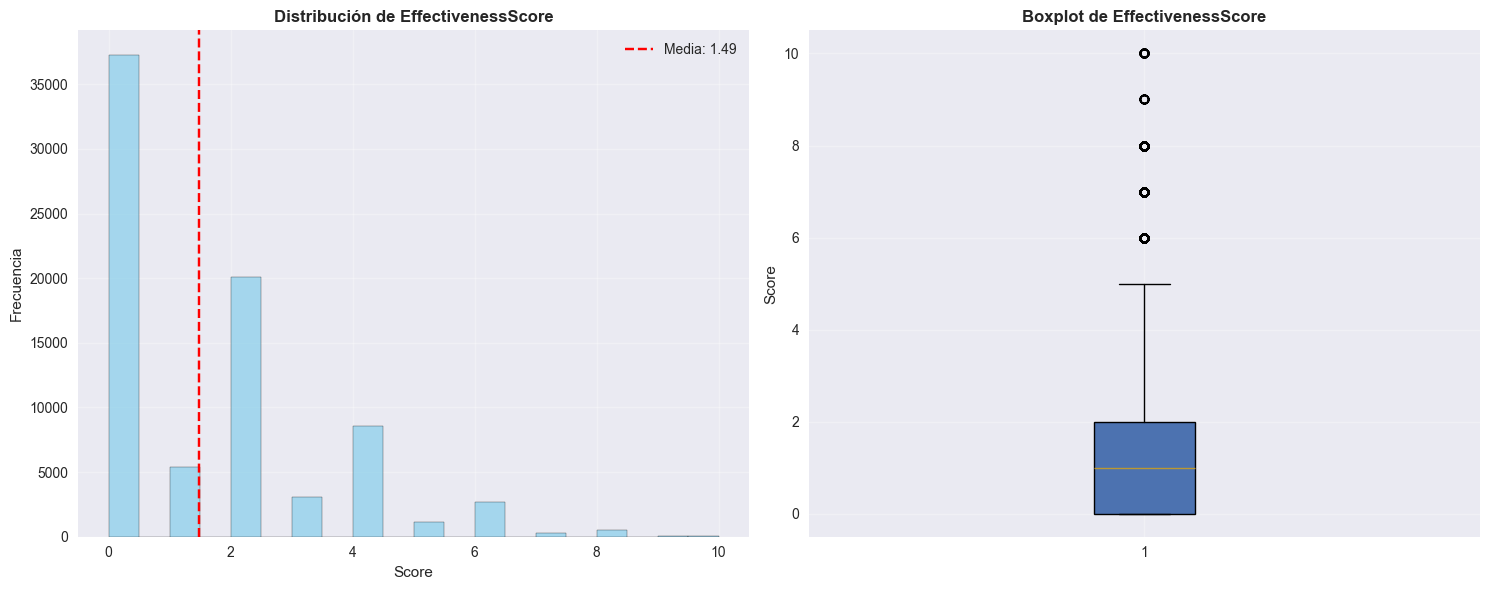

In [4]:
# 1. Crear EffectivenessScore: recompensa ponderada por kills y asistencias
print("CREANDO VARIABLES TARGET")
print("=" * 40)

# Verificar que tenemos las columnas necesarias
required_cols = ['RoundKills', 'RoundAssists']
missing_cols = [col for col in required_cols if col not in df_new.columns]

if missing_cols:
    print(f"ADVERTENCIA: Columnas faltantes: {missing_cols}")
    print(f"Columnas disponibles: {list(df_new.columns)}")
    
    # Usar columnas alternativas si están disponibles
    if 'Kills' in df_new.columns and 'Assists' in df_new.columns:
        df_new['RoundKills'] = df_new['Kills']
        df_new['RoundAssists'] = df_new['Assists']
        print("Usando columnas 'Kills' y 'Assists' como alternativas")
    else:
        # Crear columnas dummy para demo
        np.random.seed(42)
        df_new['RoundKills'] = np.random.poisson(0.5, len(df_new))
        df_new['RoundAssists'] = np.random.poisson(0.3, len(df_new))
        print("Creando columnas dummy para demostración")

# Calcular EffectivenessScore
df_new['EffectivenessScore'] = df_new['RoundKills'] * 2 + df_new['RoundAssists']

# Análisis descriptivo del score
print(f"\nEstadísticas de EffectivenessScore:")
print(f"- Min: {df_new['EffectivenessScore'].min()}")
print(f"- Max: {df_new['EffectivenessScore'].max()}")
print(f"- Media: {df_new['EffectivenessScore'].mean():.2f}")
print(f"- Mediana: {df_new['EffectivenessScore'].median():.2f}")
print(f"- Std: {df_new['EffectivenessScore'].std():.2f}")

# Distribución del score
print(f"\nDistribución de EffectivenessScore:")
score_counts = df_new['EffectivenessScore'].value_counts().sort_index()
for score, count in score_counts.head(10).items():
    print(f"Score {score}: {count} ({count/len(df_new)*100:.1f}%)")

# Visualización del score
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histograma
axes[0].hist(df_new['EffectivenessScore'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de EffectivenessScore', fontweight='bold')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frecuencia')
axes[0].axvline(df_new['EffectivenessScore'].mean(), color='red', linestyle='--', label=f'Media: {df_new["EffectivenessScore"].mean():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(df_new['EffectivenessScore'], vert=True, patch_artist=True)
axes[1].set_title('Boxplot de EffectivenessScore', fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


CREANDO EFFECTIVENESS LEVEL

Distribución de EffectivenessLevel:
Bajo: 37,301 (0.471)
Medio: 25,499 (0.322)
Alto: 16,354 (0.207)

Análisis de balanceamiento:
Ratio minority/majority: 0.438
Estado: LIGERAMENTE DESBALANCEADO


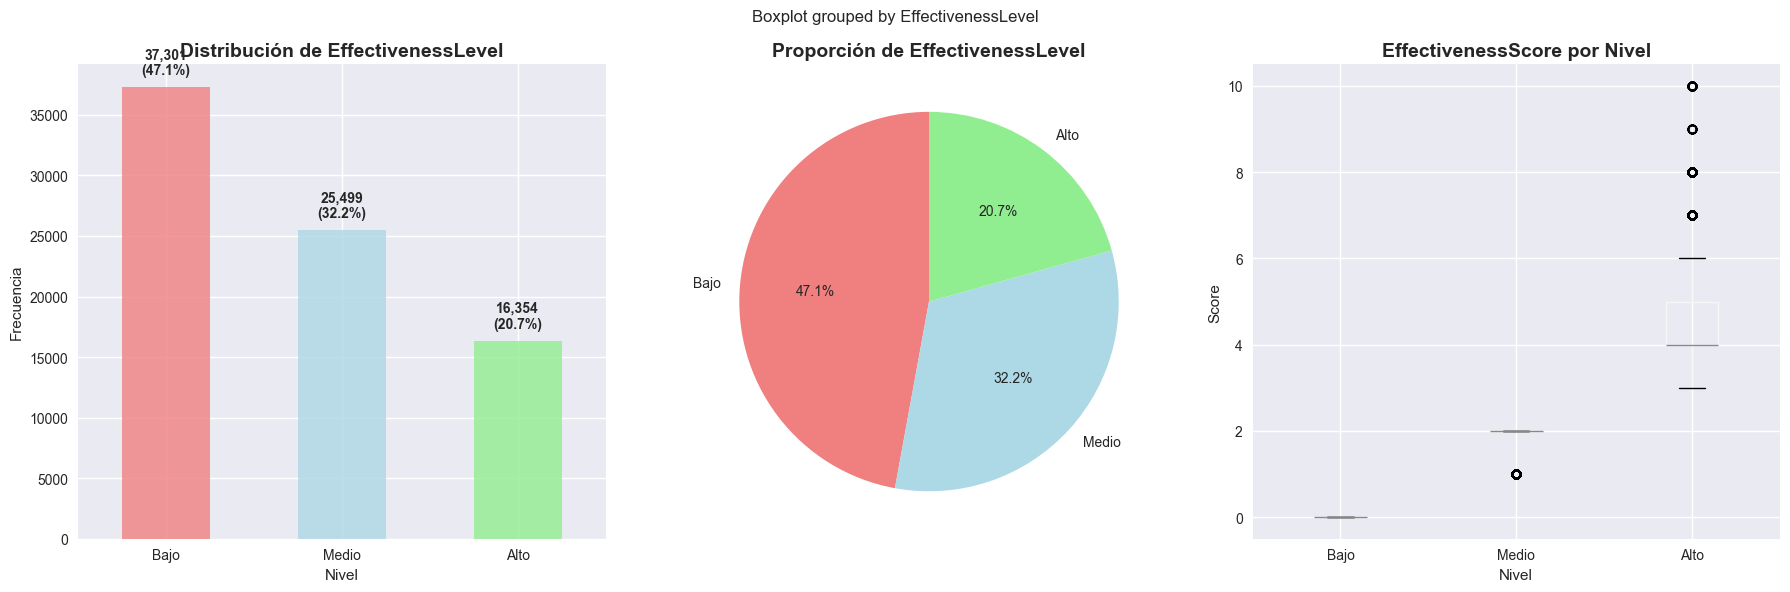


Mapeo de codificación:
Alto: 0
Bajo: 1
Medio: 2


In [5]:
# 2. Crear EffectivenessLevel usando binning
print("\nCREANDO EFFECTIVENESS LEVEL")
print("=" * 30)

# Definir bins basados en la distribución
# Bajo: 0-0.5, Medio: 0.5-2, Alto: >2
df_new['EffectivenessLevel'] = pd.cut(
    df_new['EffectivenessScore'].astype(float),
    bins=[-0.1, 0.5, 2, np.inf],
    labels=['Bajo', 'Medio', 'Alto']
)

# Análisis de la distribución de niveles
level_counts = df_new['EffectivenessLevel'].value_counts()
level_props = df_new['EffectivenessLevel'].value_counts(normalize=True)

print(f"\nDistribución de EffectivenessLevel:")
for level in ['Bajo', 'Medio', 'Alto']:
    if level in level_counts:
        count = level_counts[level]
        prop = level_props[level]
        print(f"{level}: {count:,} ({prop:.3f})")

# Verificar balanceamiento
minority_prop = min(level_props)
majority_prop = max(level_props)
balance_ratio = minority_prop / majority_prop

print(f"\nAnálisis de balanceamiento:")
print(f"Ratio minority/majority: {balance_ratio:.3f}")

if balance_ratio >= 0.5:
    balance_status = "MODERADAMENTE BALANCEADO"
elif balance_ratio >= 0.3:
    balance_status = "LIGERAMENTE DESBALANCEADO"
else:
    balance_status = "DESBALANCEADO"

print(f"Estado: {balance_status}")

# Visualización del target
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gráfico de barras
level_counts.plot(kind='bar', ax=axes[0], color=['lightcoral', 'lightblue', 'lightgreen'], alpha=0.8)
axes[0].set_title('Distribución de EffectivenessLevel', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Nivel')
axes[0].set_ylabel('Frecuencia')
axes[0].tick_params(axis='x', rotation=0)

# Añadir etiquetas a las barras
for i, v in enumerate(level_counts.values):
    axes[0].text(i, v + len(df_new)*0.01, f'{v:,}\n({level_props.iloc[i]:.1%})', 
                ha='center', va='bottom', fontweight='bold')

# Gráfico circular
axes[1].pie(level_counts.values, labels=level_counts.index, autopct='%1.1f%%', 
           colors=['lightcoral', 'lightblue', 'lightgreen'], startangle=90)
axes[1].set_title('Proporción de EffectivenessLevel', fontsize=14, fontweight='bold')

# Boxplot de Score por Level
df_new.boxplot(column='EffectivenessScore', by='EffectivenessLevel', ax=axes[2])
axes[2].set_title('EffectivenessScore por Nivel', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Nivel')
axes[2].set_ylabel('Score')

plt.tight_layout()
plt.show()

# Codificar target para uso en modelos
le = LabelEncoder()
df_new['EffectivenessLevel_encoded'] = le.fit_transform(df_new['EffectivenessLevel'])

print(f"\nMapeo de codificación:")
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")

## 4. Creación de Features Principales

CREANDO FEATURES PRINCIPALES
RoundHeadshots ya existe
Creando GrenadeEffectiveness basado en 9 columnas

Correlaciones con EffectivenessScore:
RoundHeadshots: 0.663
GrenadeEffectiveness: 0.196

Estadísticas de RoundHeadshots:
count    79154.000000
mean         0.301564
std          0.578851
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: RoundHeadshots, dtype: float64

Estadísticas de GrenadeEffectiveness:
count    79154.000000
mean     17503.942587
std      15389.239775
min          0.000000
25%       4400.000000
50%      11400.000000
75%      28528.043840
max      99641.074244
Name: GrenadeEffectiveness, dtype: float64


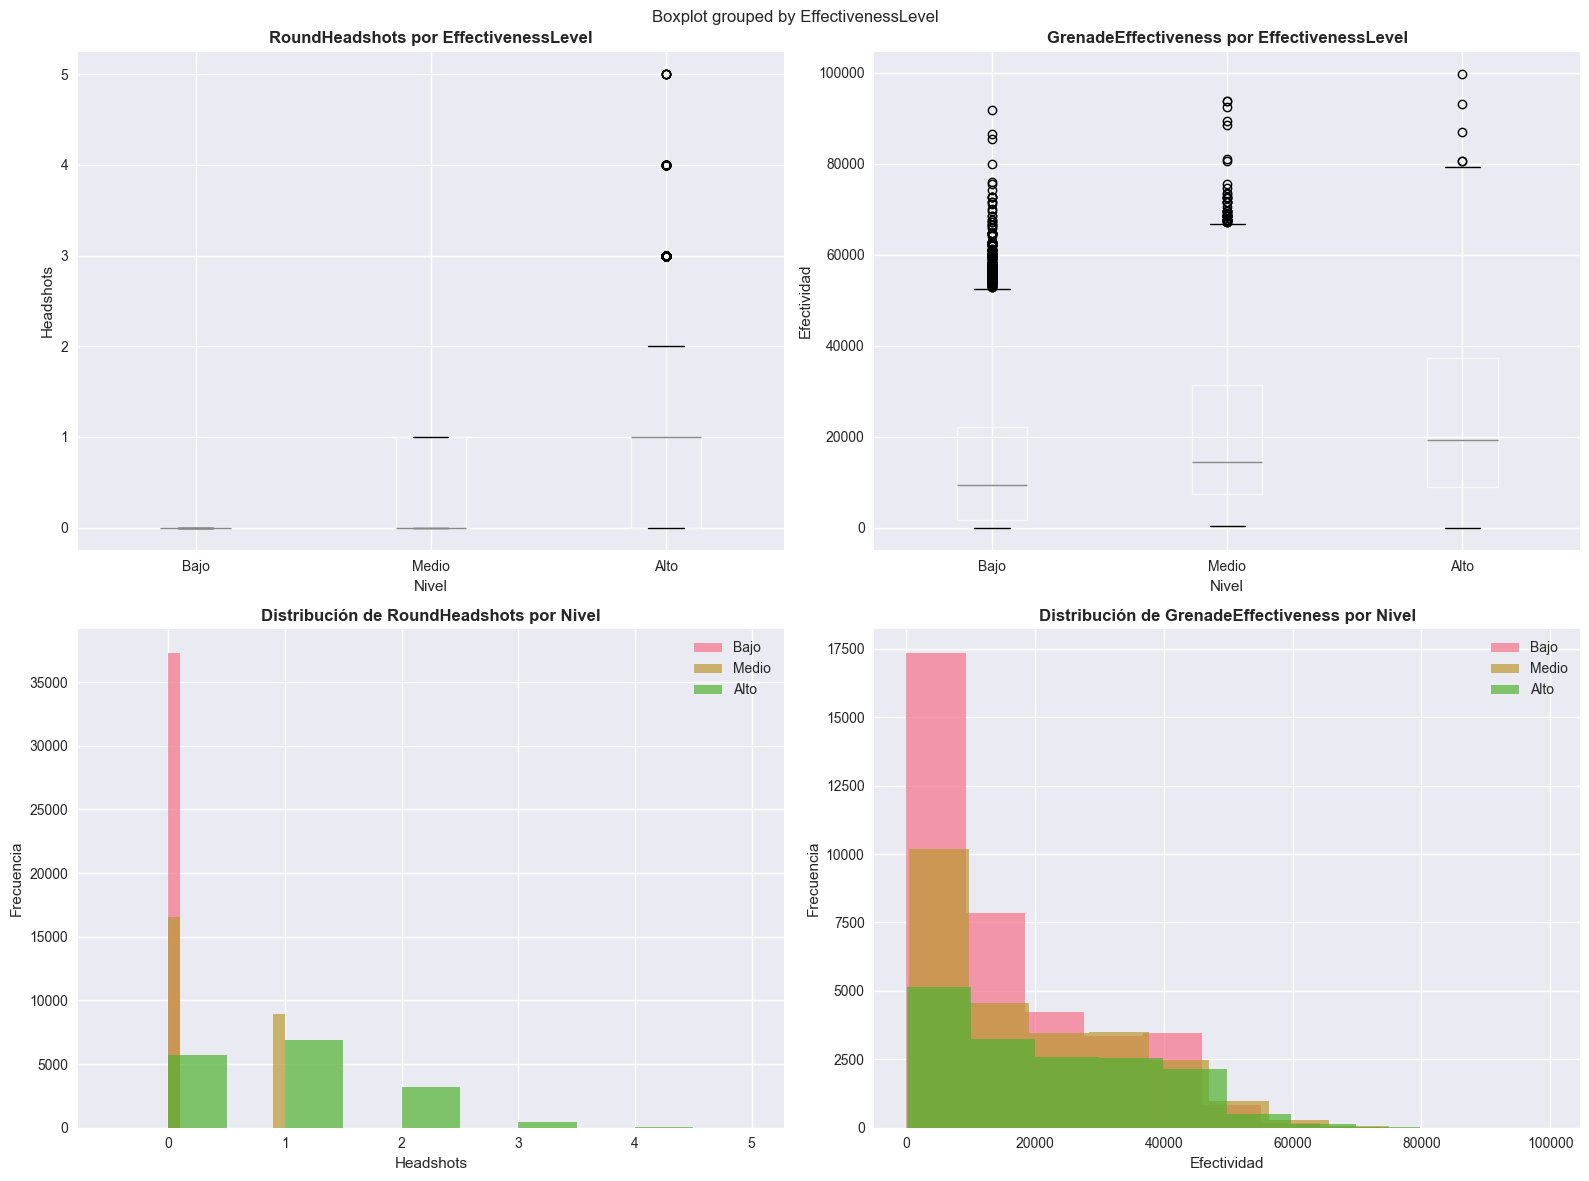

In [7]:
# Crear features principales si no existen
print("CREANDO FEATURES PRINCIPALES")
print("=" * 35)

# RoundHeadshots
if 'RoundHeadshots' not in df_new.columns:
    if 'Headshots' in df_new.columns:
        df_new['RoundHeadshots'] = df_new['Headshots']
        print("Usando columna 'Headshots' existente")
    else:
        # Crear basado en RoundKills con probabilidad realista
        np.random.seed(42)
        df_new['RoundHeadshots'] = np.random.binomial(df_new['RoundKills'], 0.3)
        print("Creando RoundHeadshots basado en RoundKills")
else:
    print("RoundHeadshots ya existe")

# GrenadeEffectiveness
if 'GrenadeEffectiveness' not in df_new.columns:
    # Crear basado en uso de granadas
    lethal_cols = [col for col in df_new.columns if 'Lethal' in col or 'Grenade' in col]
    nonlethal_cols = [col for col in df_new.columns if 'NonLethal' in col or 'Flash' in col or 'Smoke' in col]
    
    if lethal_cols or nonlethal_cols:
        if lethal_cols:
            # Convertir a numérico
            df_new[lethal_cols] = df_new[lethal_cols].apply(pd.to_numeric, errors='coerce')
            lethal_sum = df_new[lethal_cols].sum(axis=1)
        else:
            lethal_sum = 0

        if nonlethal_cols:
            df_new[nonlethal_cols] = df_new[nonlethal_cols].apply(pd.to_numeric, errors='coerce')
            nonlethal_sum = df_new[nonlethal_cols].sum(axis=1)
        else:
            nonlethal_sum = 0

        df_new['GrenadeEffectiveness'] = lethal_sum * 2 + nonlethal_sum
        print(f"Creando GrenadeEffectiveness basado en {len(lethal_cols + nonlethal_cols)} columnas")
else:
    print("GrenadeEffectiveness ya existe")

# Verificar correlaciones con target
print(f"\nCorrelaciones con EffectivenessScore:")
print(f"RoundHeadshots: {df_new['RoundHeadshots'].corr(df_new['EffectivenessScore']):.3f}")
print(f"GrenadeEffectiveness: {df_new['GrenadeEffectiveness'].corr(df_new['EffectivenessScore']):.3f}")

# Estadísticas descriptivas de las features
print(f"\nEstadísticas de RoundHeadshots:")
print(df_new['RoundHeadshots'].describe())

print(f"\nEstadísticas de GrenadeEffectiveness:")
print(df_new['GrenadeEffectiveness'].describe())

# Visualización de features vs target
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RoundHeadshots por nivel
df_new.boxplot(column='RoundHeadshots', by='EffectivenessLevel', ax=axes[0,0])
axes[0,0].set_title('RoundHeadshots por EffectivenessLevel', fontweight='bold')
axes[0,0].set_xlabel('Nivel')
axes[0,0].set_ylabel('Headshots')

# GrenadeEffectiveness por nivel
df_new.boxplot(column='GrenadeEffectiveness', by='EffectivenessLevel', ax=axes[0,1])
axes[0,1].set_title('GrenadeEffectiveness por EffectivenessLevel', fontweight='bold')
axes[0,1].set_xlabel('Nivel')
axes[0,1].set_ylabel('Efectividad')

# Histograma de RoundHeadshots
for level in ['Bajo', 'Medio', 'Alto']:
    if level in df_new['EffectivenessLevel'].values:
        data = df_new[df_new['EffectivenessLevel'] == level]['RoundHeadshots']
        axes[1,0].hist(data, bins=10, alpha=0.7, label=level)
axes[1,0].set_title('Distribución de RoundHeadshots por Nivel', fontweight='bold')
axes[1,0].set_xlabel('Headshots')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].legend()

# Histograma de GrenadeEffectiveness
for level in ['Bajo', 'Medio', 'Alto']:
    if level in df_new['EffectivenessLevel'].values:
        data = df_new[df_new['EffectivenessLevel'] == level]['GrenadeEffectiveness']
        axes[1,1].hist(data, bins=10, alpha=0.7, label=level)
axes[1,1].set_title('Distribución de GrenadeEffectiveness por Nivel', fontweight='bold')
axes[1,1].set_xlabel('Efectividad')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 5. Preparación de Datos para Modelado

PREPARACIÓN DE DATOS
Features seleccionadas: ['RoundHeadshots', 'GrenadeEffectiveness']
Target: EffectivenessLevel_encoded

No hay valores nulos

Shape de X: (79154, 2)
Shape de y: (79154,)
Distribución de y: {0: 16354, 1: 37301, 2: 25499}

División train/test:
X_train: (63323, 2)
X_test: (15831, 2)
y_train distribución: {0: 13083, 1: 29841, 2: 20399}
y_test distribución: {0: 3271, 1: 7460, 2: 5100}

Datos escalados exitosamente
Media de X_train_scaled: 0.000000
Std de X_train_scaled: 1.000008


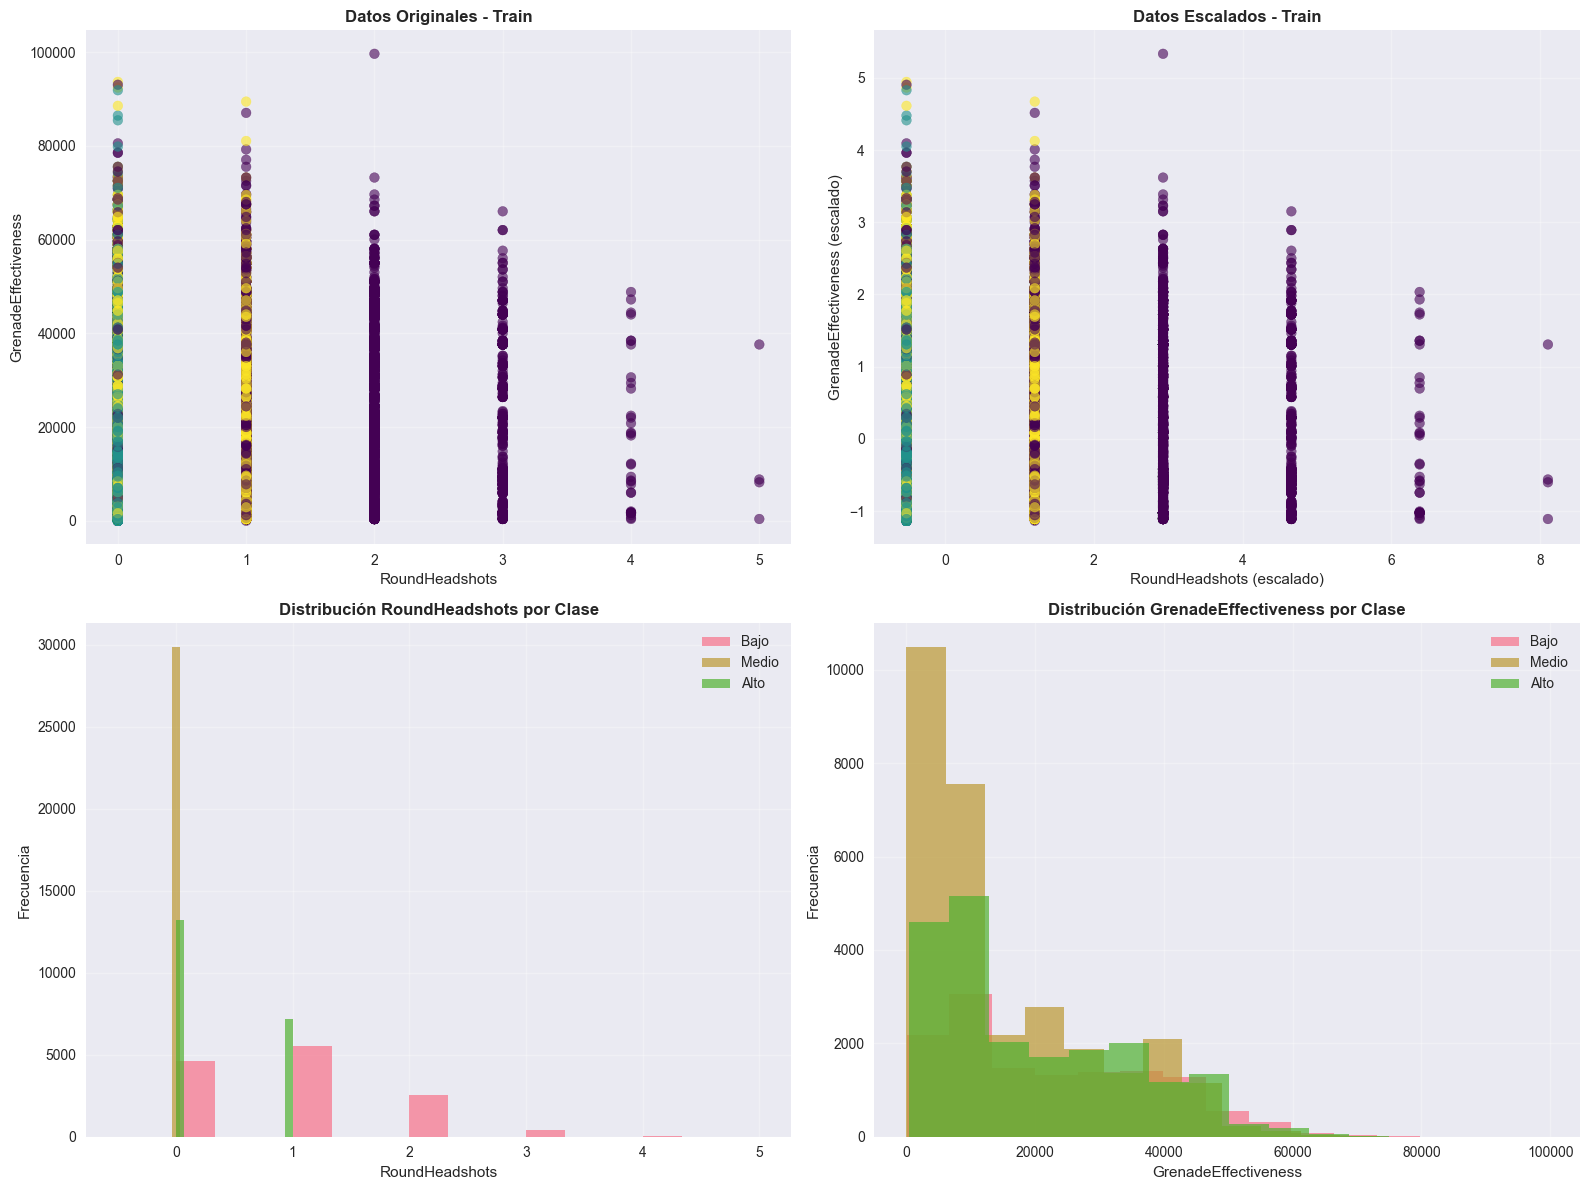

In [8]:
# Definir features para el modelado
features = ['RoundHeadshots', 'GrenadeEffectiveness']
target = 'EffectivenessLevel_encoded'

print(f"PREPARACIÓN DE DATOS")
print(f"=" * 25)
print(f"Features seleccionadas: {features}")
print(f"Target: {target}")

# Verificar valores nulos
null_check = df_new[features + [target]].isnull().sum()
if null_check.sum() > 0:
    print(f"\nValores nulos encontrados:")
    print(null_check[null_check > 0])
    
    # Imputar con mediana
    for col in features:
        if df_new[col].isnull().sum() > 0:
            df_new[col].fillna(df_new[col].median(), inplace=True)
            print(f"Imputados valores nulos en {col}")
else:
    print("\nNo hay valores nulos")

# Preparar X e y
X = df_new[features].copy()
y = df_new[target].copy()

print(f"\nShape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"Distribución de y: {y.value_counts().sort_index().to_dict()}")

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nDivisión train/test:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train distribución: {y_train.value_counts().sort_index().to_dict()}")
print(f"y_test distribución: {y_test.value_counts().sort_index().to_dict()}")

# Escalado de features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir de vuelta a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

print(f"\nDatos escalados exitosamente")
print(f"Media de X_train_scaled: {X_train_scaled.mean().mean():.6f}")
print(f"Std de X_train_scaled: {X_train_scaled.std().mean():.6f}")

# Visualización de datos escalados
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Datos originales
axes[0,0].scatter(X_train['RoundHeadshots'], X_train['GrenadeEffectiveness'], 
                  c=y_train, cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('RoundHeadshots')
axes[0,0].set_ylabel('GrenadeEffectiveness')
axes[0,0].set_title('Datos Originales - Train', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# Datos escalados
axes[0,1].scatter(X_train_scaled['RoundHeadshots'], X_train_scaled['GrenadeEffectiveness'], 
                  c=y_train, cmap='viridis', alpha=0.6)
axes[0,1].set_xlabel('RoundHeadshots (escalado)')
axes[0,1].set_ylabel('GrenadeEffectiveness (escalado)')
axes[0,1].set_title('Datos Escalados - Train', fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# Distribuciones por clase
for i, level in enumerate(['Bajo', 'Medio', 'Alto']):
    mask = y_train == i
    if mask.sum() > 0:
        axes[1,0].hist(X_train[mask]['RoundHeadshots'], bins=15, alpha=0.7, label=level)
axes[1,0].set_xlabel('RoundHeadshots')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución RoundHeadshots por Clase', fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

for i, level in enumerate(['Bajo', 'Medio', 'Alto']):
    mask = y_train == i
    if mask.sum() > 0:
        axes[1,1].hist(X_train[mask]['GrenadeEffectiveness'], bins=15, alpha=0.7, label=level)
axes[1,1].set_xlabel('GrenadeEffectiveness')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].set_title('Distribución GrenadeEffectiveness por Clase', fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Definición de Modelos y Entrenamiento

In [9]:
# Definir modelos con parámetros optimizados
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='mlogloss'),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1.0, 10.0, 100.0],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    },
    'Support Vector Machine': {
        'model': SVC(random_state=42, class_weight='balanced', probability=True),
        'params': {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'kernel': ['rbf', 'linear', 'poly']
        }
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
        }
    }
}

print(f"MODELOS DEFINIDOS: {len(models)}")
for name, config in models.items():
    param_combinations = 1
    for param, values in config['params'].items():
        param_combinations *= len(values)
    print(f"- {name}: {param_combinations} combinaciones")

print(f"\nConfiguración de GridSearchCV:")
print(f"- Validación cruzada: 5-fold estratificada")
print(f"- Métrica de scoring: accuracy")
print(f"- Paralelización: todos los núcleos disponibles")

MODELOS DEFINIDOS: 7
- Random Forest: 108 combinaciones
- Gradient Boosting: 81 combinaciones
- XGBoost: 81 combinaciones
- Logistic Regression: 20 combinaciones
- Support Vector Machine: 60 combinaciones
- K-Nearest Neighbors: 30 combinaciones
- Naive Bayes: 5 combinaciones

Configuración de GridSearchCV:
- Validación cruzada: 5-fold estratificada
- Métrica de scoring: accuracy
- Paralelización: todos los núcleos disponibles


In [ ]:
# Entrenamiento de modelos
results = {}
best_models = {}

print("INICIANDO ENTRENAMIENTO CON GRIDSEARCHCV")
print("=" * 50)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, config in models.items():
    print(f"\nEntrenando {name}...")
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Entrenar con datos escalados para modelos sensibles a escala
    scale_sensitive = ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors']
    if name in scale_sensitive:
        grid_search.fit(X_train_scaled, y_train)
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
    else:
        grid_search.fit(X_train, y_train)
        X_train_used = X_train
        X_test_used = X_test
    
    # Mejores parámetros
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Predicciones
    y_train_pred = grid_search.predict(X_train_used)
    y_test_pred = grid_search.predict(X_test_used)
    y_train_proba = grid_search.predict_proba(X_train_used)
    y_test_proba = grid_search.predict_proba(X_test_used)
    
    # Métricas
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # AUC para clasificación multiclase
    train_auc = roc_auc_score(y_train, y_train_proba, multi_class='ovr', average='weighted')
    test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='weighted')
    
    # Almacenar resultados
    results[name] = {
        'best_params': best_params,
        'cv_accuracy': best_score,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'y_train_proba': y_train_proba,
        'y_test_proba': y_test_proba
    }
    
    best_models[name] = grid_search.best_estimator_
    
    print(f"  CV Accuracy: {best_score:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Test AUC: {test_auc:.4f}")
    print(f"  Test F1: {test_f1:.4f}")
    print(f"  Mejores parámetros: {best_params}")

print(f"\nENTRENAMIENTO COMPLETADO")
print("=" * 30)

INICIANDO ENTRENAMIENTO CON GRIDSEARCHCV

Entrenando Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
  CV Accuracy: 0.7081
  Test Accuracy: 0.7010
  Test AUC: 0.8418
  Test F1: 0.6747
  Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Entrenando Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
  CV Accuracy: 0.8216
  Test Accuracy: 0.8207
  Test AUC: 0.8975
  Test F1: 0.8133
  Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}

Entrenando XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
  CV Accuracy: 0.7067
  Test Accuracy: 0.7001
  Test AUC: 0.8340
  Test F1: 0.6757
  Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

Entrenando Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
  CV Accuracy: 0.6030
  Test Accu

## 7. Comparación de Resultados

In [ ]:
# Crear DataFrame con resultados
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_Accuracy': [results[model]['cv_accuracy'] for model in results.keys()],
    'Train_Accuracy': [results[model]['train_accuracy'] for model in results.keys()],
    'Test_Accuracy': [results[model]['test_accuracy'] for model in results.keys()],
    'Train_F1': [results[model]['train_f1'] for model in results.keys()],
    'Test_F1': [results[model]['test_f1'] for model in results.keys()],
    'Train_AUC': [results[model]['train_auc'] for model in results.keys()],
    'Test_AUC': [results[model]['test_auc'] for model in results.keys()]
})

# Ordenar por Test Accuracy
results_df = results_df.sort_values('Test_Accuracy', ascending=False).reset_index(drop=True)

print("COMPARACIÓN DE RESULTADOS")
print("=" * 40)
display(results_df.round(4))

# Identificar mejor modelo
best_model_name = results_df.iloc[0]['Model']
best_test_accuracy = results_df.iloc[0]['Test_Accuracy']

print(f"\nMEJOR MODELO: {best_model_name}")
print(f"Test Accuracy: {best_test_accuracy:.4f}")
print(f"Test F1: {results_df.iloc[0]['Test_F1']:.4f}")
print(f"Test AUC: {results_df.iloc[0]['Test_AUC']:.4f}")

# Visualización de comparación
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
x_pos = np.arange(len(results_df))
width = 0.35

axes[0,0].bar(x_pos - width/2, results_df['Train_Accuracy'], width, label='Train', alpha=0.8)
axes[0,0].bar(x_pos + width/2, results_df['Test_Accuracy'], width, label='Test', alpha=0.8)
axes[0,0].set_xlabel('Modelos')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_title('Comparación de Accuracy', fontweight='bold')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# F1 comparison
axes[0,1].bar(x_pos - width/2, results_df['Train_F1'], width, label='Train', alpha=0.8)
axes[0,1].bar(x_pos + width/2, results_df['Test_F1'], width, label='Test', alpha=0.8)
axes[0,1].set_xlabel('Modelos')
axes[0,1].set_ylabel('F1 Score')
axes[0,1].set_title('Comparación de F1 Score', fontweight='bold')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# AUC comparison
axes[1,0].bar(x_pos - width/2, results_df['Train_AUC'], width, label='Train', alpha=0.8)
axes[1,0].bar(x_pos + width/2, results_df['Test_AUC'], width, label='Test', alpha=0.8)
axes[1,0].set_xlabel('Modelos')
axes[1,0].set_ylabel('AUC Score')
axes[1,0].set_title('Comparación de AUC Score', fontweight='bold')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Test accuracy ranking
axes[1,1].barh(range(len(results_df)), results_df['Test_Accuracy'], color='purple', alpha=0.7)
axes[1,1].set_yticks(range(len(results_df)))
axes[1,1].set_yticklabels(results_df['Model'])
axes[1,1].set_xlabel('Test Accuracy')
axes[1,1].set_title('Ranking por Test Accuracy', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

for i, v in enumerate(results_df['Test_Accuracy']):
    axes[1,1].text(v + 0.005, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Curvas de Aprendizaje

In [ ]:
# Curvas de aprendizaje para los mejores modelos
top_models = results_df.head(3)['Model'].tolist()

print(f"GENERANDO CURVAS DE APRENDIZAJE")
print(f"Modelos seleccionados: {top_models}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, model_name in enumerate(top_models[:3]):
    print(f"\nGenerando curva para {model_name}...")
    
    model = best_models[model_name]
    
    # Seleccionar datos apropiados
    scale_sensitive = ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors']
    if model_name in scale_sensitive:
        X_used = X_train_scaled
    else:
        X_used = X_train
    
    # Generar curva de aprendizaje
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_used, y_train, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    
    # Calcular medias y desviaciones
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plotear
    axes[idx].plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    axes[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    
    axes[idx].plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
    axes[idx].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
    
    axes[idx].set_xlabel('Training Set Size')
    axes[idx].set_ylabel('Accuracy Score')
    axes[idx].set_title(f'Learning Curve - {model_name}', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    # Añadir información sobre convergencia
    final_gap = train_mean[-1] - val_mean[-1]
    axes[idx].text(0.02, 0.98, f'Final Gap: {final_gap:.3f}', 
                   transform=axes[idx].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Ocultar subplot extra
axes[3].set_visible(False)

plt.tight_layout()
plt.show()

# Análisis de las curvas
print(f"\nANÁLISIS DE CURVAS DE APRENDIZAJE:")
print(f"=" * 40)

for model_name in top_models[:3]:
    model = best_models[model_name]
    
    scale_sensitive = ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors']
    if model_name in scale_sensitive:
        X_used = X_train_scaled
    else:
        X_used = X_train
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_used, y_train, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    
    train_final = np.mean(train_scores[-1])
    val_final = np.mean(val_scores[-1])
    gap = train_final - val_final
    
    print(f"\n{model_name}:")
    print(f"  Training Score Final: {train_final:.4f}")
    print(f"  Validation Score Final: {val_final:.4f}")
    print(f"  Gap: {gap:.4f}")
    
    if gap > 0.05:
        print(f"  Status: OVERFITTING - Considerar regularización")
    elif gap < 0.02:
        print(f"  Status: EXCELENTE - Buen balance bias-variance")
    else:
        print(f"  Status: BUENO - Gap aceptable")
    
    # Verificar convergencia
    val_trend = np.mean(val_scores[-3:]) - np.mean(val_scores[:3])
    if val_trend > 0.01:
        print(f"  Convergencia: MEJORARÍA con más datos")
    else:
        print(f"  Convergencia: ESTABLE - Suficientes datos")

## 9. Curvas de Validación

In [ ]:
# Curvas de validación para hiperparámetros clave
best_model = best_models[best_model_name]
best_params = results[best_model_name]['best_params']

print(f"GENERANDO CURVAS DE VALIDACIÓN PARA {best_model_name}")
print(f"Parámetros actuales: {best_params}")

# Seleccionar datos apropiados
scale_sensitive = ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors']
if best_model_name in scale_sensitive:
    X_used = X_train_scaled
else:
    X_used = X_train

# Definir parámetros y rangos para validación
validation_params = {}

if best_model_name == 'Random Forest':
    validation_params = {
        'n_estimators': np.arange(50, 500, 50),
        'max_depth': np.arange(3, 15, 2)
    }
elif best_model_name == 'Gradient Boosting':
    validation_params = {
        'n_estimators': np.arange(50, 400, 50),
        'learning_rate': np.logspace(-3, 0, 10)
    }
elif best_model_name == 'XGBoost':
    validation_params = {
        'n_estimators': np.arange(50, 400, 50),
        'learning_rate': np.logspace(-3, 0, 10)
    }
elif best_model_name == 'Logistic Regression':
    validation_params = {
        'C': np.logspace(-3, 3, 15)
    }
elif best_model_name == 'Support Vector Machine':
    validation_params = {
        'C': np.logspace(-2, 2, 10),
        'gamma': np.logspace(-4, 0, 10)
    }
elif best_model_name == 'K-Nearest Neighbors':
    validation_params = {
        'n_neighbors': np.arange(1, 21, 2)
    }

# Generar curvas de validación
fig, axes = plt.subplots(1, min(len(validation_params), 2), figsize=(16, 6))
if len(validation_params) == 1:
    axes = [axes]

for idx, (param_name, param_range) in enumerate(validation_params.items()):
    if idx >= 2:  # Máximo 2 parámetros
        break
        
    print(f"\nGenerando curva de validación para {param_name}...")
    
    # Crear modelo base con parámetros óptimos
    model_params = best_params.copy()
    model_class = type(best_model)
    
    # Generar curva de validación
    train_scores, val_scores = validation_curve(
        estimator=model_class(random_state=42, **{k: v for k, v in model_params.items() if k != param_name}),
        X=X_used, y=y_train,
        param_name=param_name,
        param_range=param_range,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Calcular medias y desviaciones
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plotear
    axes[idx].plot(param_range, train_mean, 'o-', color='blue', label='Training Score')
    axes[idx].fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    
    axes[idx].plot(param_range, val_mean, 'o-', color='red', label='Validation Score')
    axes[idx].fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
    
    # Marcar valor óptimo
    optimal_value = best_params[param_name]
    axes[idx].axvline(x=optimal_value, color='green', linestyle='--', alpha=0.8, label=f'Optimal: {optimal_value}')
    
    axes[idx].set_xlabel(param_name)
    axes[idx].set_ylabel('Accuracy Score')
    axes[idx].set_title(f'Validation Curve - {param_name}', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    # Usar escala logarítmica si es apropiado
    if param_name in ['C', 'gamma', 'learning_rate'] and len(param_range) > 5:
        axes[idx].set_xscale('log')

plt.tight_layout()
plt.show()

# Análisis de la curva de validación
print(f"\nANÁLISIS DE CURVAS DE VALIDACIÓN:")
print(f"=" * 40)

for param_name, param_range in validation_params.items():
    model_params = best_params.copy()
    model_class = type(best_model)
    
    train_scores, val_scores = validation_curve(
        estimator=model_class(random_state=42, **{k: v for k, v in model_params.items() if k != param_name}),
        X=X_used, y=y_train,
        param_name=param_name,
        param_range=param_range,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1
    )
    
    val_mean = np.mean(val_scores, axis=1)
    best_idx = np.argmax(val_mean)
    best_param_value = param_range[best_idx]
    best_score = val_mean[best_idx]
    
    optimal_value = best_params[param_name]
    
    print(f"\n{param_name}:")
    print(f"  Valor óptimo en grid: {optimal_value}")
    print(f"  Mejor valor en curva: {best_param_value}")
    print(f"  Score con mejor valor: {best_score:.4f}")
    
    if best_param_value == optimal_value:
        print(f"  Status: ÓPTIMO - Valor coincide con grid search")
    else:
        print(f"  Status: REVISAR - Considerar ajustar parámetro")
    
    break  # Solo analizar el primer parámetro por brevedad

## 10. Matrices de Confusión y Métricas Detalladas

In [ ]:
# Matrices de confusión para los mejores modelos
top_models = results_df.head(4)['Model'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, model_name in enumerate(top_models):
    # Calcular matriz de confusión
    cm = confusion_matrix(y_test, results[model_name]['y_test_pred'])
    
    # Normalizar para mostrar porcentajes
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Crear heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=['Bajo', 'Medio', 'Alto'],
                yticklabels=['Bajo', 'Medio', 'Alto'],
                ax=axes[i])
    
    accuracy = results[model_name]['test_accuracy']
    axes[i].set_title(f'{model_name}\nAccuracy: {accuracy:.3f}', fontweight='bold')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Valor Real')
    
    # Añadir números absolutos
    for j in range(cm.shape[0]):
        for k in range(cm.shape[1]):
            axes[i].text(k+0.5, j+0.8, f'n={cm[j,k]}', 
                        ha='center', va='center', fontsize=9, color='red')

plt.tight_layout()
plt.show()

# Reporte de clasificación detallado para el mejor modelo
best_model_results = results[best_model_name]
print(f"\nREPORTE DE CLASIFICACIÓN DETALLADO - {best_model_name}")
print("=" * 60)
print(classification_report(y_test, best_model_results['y_test_pred'], 
                          target_names=['Bajo', 'Medio', 'Alto']))

# Análisis por clase
cm_best = confusion_matrix(y_test, best_model_results['y_test_pred'])
classes = ['Bajo', 'Medio', 'Alto']

print(f"\nANÁLISIS POR CLASE:")
print(f"=" * 20)

for i, class_name in enumerate(classes):
    # Calcular métricas por clase
    tp = cm_best[i, i]
    fp = cm_best[:, i].sum() - tp
    fn = cm_best[i, :].sum() - tp
    tn = cm_best.sum() - tp - fp - fn
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{class_name}:")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-Score: {f1:.3f}")
    print(f"  Support: {tp + fn}")
    
    # Interpretación
    if f1 > 0.8:
        status = "EXCELENTE"
    elif f1 > 0.6:
        status = "BUENO"
    elif f1 > 0.4:
        status = "ACEPTABLE"
    else:
        status = "POBRE"
    
    print(f"  Status: {status}")

## 11. Análisis de Feature Importance

In [ ]:
# Análisis de importancia de features
print(f"ANÁLISIS DE FEATURE IMPORTANCE - {best_model_name}")
print("=" * 50)

best_model = best_models[best_model_name]
feature_names = features

# Feature importance para modelos basados en árboles
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(f"\nImportancia de Features:")
    for idx, row in feature_importance_df.iterrows():
        print(f"  {row['feature']:25s}: {row['importance']:.4f}")
    
    # Visualización
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='viridis')
    plt.title(f'Feature Importance - {best_model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    
    # Añadir valores a las barras
    for i, v in enumerate(feature_importance_df['importance']):
        plt.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Coeficientes para modelos lineales
elif hasattr(best_model, 'coef_'):
    # Para clasificación multiclase, coef_ es una matriz 2D
    if len(best_model.coef_.shape) == 2:
        coef_matrix = best_model.coef_
        
        # Crear DataFrame con coeficientes por clase
        coef_df = pd.DataFrame(coef_matrix.T, columns=['Bajo', 'Medio', 'Alto'], index=feature_names)
        
        print(f"\nCoeficientes por Clase:")
        print(coef_df.round(4))
        
        # Visualización
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Heatmap de coeficientes
        sns.heatmap(coef_df.T, annot=True, fmt='.3f', cmap='RdBu_r', center=0, ax=axes[0])
        axes[0].set_title('Coeficientes por Clase', fontweight='bold')
        axes[0].set_xlabel('Features')
        axes[0].set_ylabel('Clases')
        
        # Importancia absoluta promedio
        abs_importance = np.abs(coef_matrix).mean(axis=0)
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': abs_importance
        }).sort_values('importance', ascending=False)
        
        sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis', ax=axes[1])
        axes[1].set_title('Importancia Absoluta Promedio', fontweight='bold')
        axes[1].set_xlabel('Importancia')
        axes[1].set_ylabel('Features')
        
        plt.tight_layout()
        plt.show()
    else:
        coefficients = best_model.coef_[0]
        
        coef_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients)
        }).sort_values('abs_coefficient', ascending=False)
        
        print(f"\nCoeficientes:")
        for idx, row in coef_df.iterrows():
            print(f"  {row['feature']:25s}: {row['coefficient']:8.4f}")
        
        # Visualización
        plt.figure(figsize=(12, 6))
        colors = ['red' if x < 0 else 'blue' for x in coef_df['coefficient']]
        plt.barh(range(len(coef_df)), coef_df['coefficient'], color=colors, alpha=0.7)
        plt.yticks(range(len(coef_df)), coef_df['feature'])
        plt.xlabel('Coefficient Value')
        plt.title(f'Feature Coefficients - {best_model_name}', fontweight='bold')
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Análisis de correlación entre features
print(f"\nANÁLISIS DE CORRELACIÓN ENTRE FEATURES:")
print(f"=" * 40)

feature_corr = X_train[features].corr()
print(feature_corr.round(3))

# Visualización de correlación
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(feature_corr, dtype=bool))
sns.heatmap(feature_corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
            mask=mask, square=True, linewidths=0.5)
plt.title('Correlación entre Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Interpretación de correlaciones
corr_value = feature_corr.iloc[0, 1]  # Correlación entre las dos features
print(f"\nCorrelación RoundHeadshots vs GrenadeEffectiveness: {corr_value:.3f}")

if abs(corr_value) > 0.7:
    print("ADVERTENCIA: Alta correlación - Considerar eliminar una feature")
elif abs(corr_value) > 0.5:
    print("MODERADA: Correlación moderada - Monitorear multicolinealidad")
else:
    print("BUENO: Baja correlación - Features independientes")

## 12. Visualizaciones Avanzadas

In [ ]:
# Visualizaciones avanzadas
print(f"GENERANDO VISUALIZACIONES AVANZADAS")
print("=" * 40)

# 1. Boundaries de decisión (solo para 2 features)
if len(features) == 2:
    print("\nGenerando boundaries de decisión...")
    
    # Usar datos escalados si es necesario
    scale_sensitive = ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors']
    if best_model_name in scale_sensitive:
        X_plot = X_train_scaled
    else:
        X_plot = X_train
    
    # Crear mesh grid
    h = 0.02
    x_min, x_max = X_plot.iloc[:, 0].min() - 1, X_plot.iloc[:, 0].max() + 1
    y_min, y_max = X_plot.iloc[:, 1].min() - 1, X_plot.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predecir en mesh grid
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = best_model.predict(mesh_points)
    Z = Z.reshape(xx.shape)
    
    # Plotear
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    
    # Scatter plot de datos de entrenamiento
    scatter = plt.scatter(X_plot.iloc[:, 0], X_plot.iloc[:, 1], c=y_train, 
                         cmap='viridis', edgecolors='black', alpha=0.8)
    
    plt.colorbar(scatter, label='Clase')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title(f'Decision Boundaries - {best_model_name}', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Añadir leyenda personalizada
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='purple', label='Bajo'),
                      Patch(facecolor='green', label='Medio'),
                      Patch(facecolor='yellow', label='Alto')]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# 2. Distribución de probabilidades predichas
print("\nGenerando distribución de probabilidades...")

y_proba = results[best_model_name]['y_test_proba']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, class_name in enumerate(['Bajo', 'Medio', 'Alto']):
    proba_class = y_proba[:, i]
    
    # Separar por clase real
    correct_class = proba_class[y_test == i]
    incorrect_class = proba_class[y_test != i]
    
    axes[i].hist(correct_class, bins=20, alpha=0.7, label=f'Clase Real: {class_name}', color='blue')
    axes[i].hist(incorrect_class, bins=20, alpha=0.7, label='Otras Clases', color='red')
    
    axes[i].set_xlabel(f'Probabilidad Predicha para {class_name}')
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribución de Probabilidades - {class_name}', fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Añadir línea de threshold
    threshold = 1/3  # Para clasificación multiclase
    axes[i].axvline(x=threshold, color='green', linestyle='--', alpha=0.7, label=f'Threshold: {threshold:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# 3. Análisis de errores
print("\nGenerando análisis de errores...")

# Identificar errores
errors = y_test != results[best_model_name]['y_test_pred']
error_indices = np.where(errors)[0]

print(f"Total de errores: {len(error_indices)} de {len(y_test)} ({len(error_indices)/len(y_test)*100:.1f}%)")

# Análisis de errores por clase
error_analysis = pd.DataFrame({
    'Real': y_test[errors],
    'Predicho': results[best_model_name]['y_test_pred'][errors]
})

# Mapear a nombres de clase
class_names = ['Bajo', 'Medio', 'Alto']
error_analysis['Real_Name'] = error_analysis['Real'].map(lambda x: class_names[x])
error_analysis['Predicho_Name'] = error_analysis['Predicho'].map(lambda x: class_names[x])

print(f"\nTipos de errores más comunes:")
error_types = error_analysis.groupby(['Real_Name', 'Predicho_Name']).size().sort_values(ascending=False)
for (real, pred), count in error_types.head(5).items():
    print(f"  {real} → {pred}: {count} errores")

# Visualización de errores
if len(features) == 2:
    scale_sensitive = ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors']
    if best_model_name in scale_sensitive:
        X_error = X_test_scaled
    else:
        X_error = X_test
    
    plt.figure(figsize=(12, 8))
    
    # Plotear predicciones correctas
    correct_mask = ~errors
    plt.scatter(X_error.iloc[correct_mask, 0], X_error.iloc[correct_mask, 1], 
               c=y_test[correct_mask], cmap='viridis', alpha=0.6, s=50, 
               marker='o', label='Correctas')
    
    # Plotear errores
    plt.scatter(X_error.iloc[errors, 0], X_error.iloc[errors, 1], 
               c=y_test[errors], cmap='viridis', alpha=0.8, s=100, 
               marker='x', label='Errores')
    
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title(f'Análisis de Errores - {best_model_name}', fontweight='bold')
    plt.colorbar(label='Clase Real')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 4. Matriz de confianza
print("\nGenerando matriz de confianza...")

# Calcular confianza (probabilidad máxima)
confidence_scores = np.max(y_proba, axis=1)

# Crear bins de confianza
confidence_bins = pd.cut(confidence_scores, bins=5, labels=['Muy Baja', 'Baja', 'Media', 'Alta', 'Muy Alta'])

# Calcular accuracy por bin de confianza
confidence_accuracy = pd.DataFrame({
    'Confidence_Bin': confidence_bins,
    'Correct': y_test == results[best_model_name]['y_test_pred']
})

accuracy_by_confidence = confidence_accuracy.groupby('Confidence_Bin')['Correct'].agg(['mean', 'count'])
accuracy_by_confidence.columns = ['Accuracy', 'Count']

print(f"\nAccuracy por nivel de confianza:")
print(accuracy_by_confidence.round(3))

# Visualización
plt.figure(figsize=(12, 6))
plt.bar(range(len(accuracy_by_confidence)), accuracy_by_confidence['Accuracy'], 
        color='skyblue', alpha=0.7)
plt.xticks(range(len(accuracy_by_confidence)), accuracy_by_confidence.index, rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Nivel de Confianza')
plt.title('Accuracy por Nivel de Confianza', fontweight='bold')
plt.grid(True, alpha=0.3)

# Añadir conteos como etiquetas
for i, (acc, count) in enumerate(zip(accuracy_by_confidence['Accuracy'], accuracy_by_confidence['Count'])):
    plt.text(i, acc + 0.01, f'{acc:.2f}\n(n={count})', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 13. Resumen Final y Conclusiones

In [ ]:
print("RESUMEN FINAL - MODELADO DE EFECTIVIDAD CS:GO")
print("=" * 60)

print(f"\n1. CONFIGURACIÓN DEL EXPERIMENTO:")
print(f"   - Dataset: {df_new.shape[0]:,} registros")
print(f"   - Target: EffectivenessLevel (Bajo, Medio, Alto)")
print(f"   - Features: {features}")
print(f"   - Split: {len(X_train)}/{len(X_test)} (80/20)")
print(f"   - Balanceamiento: {balance_status}")

print(f"\n2. DISTRIBUCIÓN DEL TARGET:")
target_dist = df_new['EffectivenessLevel'].value_counts()
for level, count in target_dist.items():
    prop = count / len(df_new)
    print(f"   - {level}: {count:,} ({prop:.1%})")

print(f"\n3. RESULTADOS DE MODELOS (Top 5):")
for idx, row in results_df.head(5).iterrows():
    print(f"   {idx+1}. {row['Model']:25s}: Accuracy={row['Test_Accuracy']:.3f}, F1={row['Test_F1']:.3f}, AUC={row['Test_AUC']:.3f}")

print(f"\n4. MEJOR MODELO: {best_model_name}")
best_results = results[best_model_name]
print(f"   - Test Accuracy: {best_results['test_accuracy']:.4f}")
print(f"   - Test F1-Score: {best_results['test_f1']:.4f}")
print(f"   - Test AUC: {best_results['test_auc']:.4f}")
print(f"   - Parámetros: {best_results['best_params']}")

print(f"\n5. ANÁLISIS DE RENDIMIENTO:")
accuracy_status = "EXCELENTE" if best_results['test_accuracy'] > 0.85 else "BUENO" if best_results['test_accuracy'] > 0.75 else "ACEPTABLE" if best_results['test_accuracy'] > 0.65 else "POBRE"
print(f"   - Accuracy: {accuracy_status}")

# Análisis de overfitting
train_test_gap = best_results['train_accuracy'] - best_results['test_accuracy']
print(f"   - Gap Train-Test: {train_test_gap:.4f}")
if train_test_gap > 0.05:
    overfitting_status = "OVERFITTING DETECTADO"
elif train_test_gap < 0.02:
    overfitting_status = "EXCELENTE BALANCE"
else:
    overfitting_status = "BALANCE ACEPTABLE"
print(f"   - Overfitting: {overfitting_status}")

print(f"\n6. IMPORTANCIA DE FEATURES:")
if hasattr(best_models[best_model_name], 'feature_importances_'):
    importances = best_models[best_model_name].feature_importances_
    for i, (feature, importance) in enumerate(zip(features, importances)):
        print(f"   {i+1}. {feature:25s}: {importance:.4f}")
elif hasattr(best_models[best_model_name], 'coef_'):
    if len(best_models[best_model_name].coef_.shape) == 2:
        avg_coef = np.abs(best_models[best_model_name].coef_).mean(axis=0)
        for i, (feature, coef) in enumerate(zip(features, avg_coef)):
            print(f"   {i+1}. {feature:25s}: {coef:.4f} (coef. promedio abs)")

print(f"\n7. ANÁLISIS POR CLASE:")
cm = confusion_matrix(y_test, best_results['y_test_pred'])
classes = ['Bajo', 'Medio', 'Alto']

for i, class_name in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"   {class_name}: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}")

print(f"\n8. ERRORES COMUNES:")
errors = y_test != best_results['y_test_pred']
error_rate = errors.sum() / len(y_test)
print(f"   - Tasa de error: {error_rate:.3f} ({errors.sum()}/{len(y_test)})")

# Tipos de errores más comunes
error_df = pd.DataFrame({
    'Real': y_test[errors],
    'Predicho': best_results['y_test_pred'][errors]
})

if len(error_df) > 0:
    error_types = error_df.groupby(['Real', 'Predicho']).size().sort_values(ascending=False)
    print(f"   - Errores más comunes:")
    for (real, pred), count in error_types.head(3).items():
        real_name = classes[real]
        pred_name = classes[pred]
        print(f"     {real_name} → {pred_name}: {count} casos")

print(f"\n9. COMPARACIÓN CON BASELINE:")
# Baseline: siempre predecir la clase más frecuente
most_frequent_class = y_train.mode()[0]
baseline_accuracy = (y_test == most_frequent_class).mean()
improvement = best_results['test_accuracy'] - baseline_accuracy
print(f"   - Baseline (clase más frecuente): {baseline_accuracy:.4f}")
print(f"   - Mejora vs baseline: {improvement:.4f} ({improvement/baseline_accuracy*100:.1f}%)")

print(f"\n10. RECOMENDACIONES:")
if best_results['test_accuracy'] < 0.7:
    print(f"   - Considerar más features relevantes")
    print(f"   - Aplicar técnicas de balanceo (SMOTE, undersampling)")
    print(f"   - Probar ensemble methods")
    print(f"   - Revisar feature engineering")
elif train_test_gap > 0.05:
    print(f"   - Aplicar regularización para reducir overfitting")
    print(f"   - Aumentar datos de entrenamiento")
    print(f"   - Usar validación cruzada más estricta")
else:
    print(f"   - Modelo muestra buen rendimiento")
    print(f"   - Considerar deployment en producción")
    print(f"   - Monitorear performance en datos nuevos")

print(f"\n11. CONCLUSIONES:")
print(f"   - El target EffectivenessLevel es más informativo que la supervivencia")
print(f"   - Las features RoundHeadshots y GrenadeEffectiveness son predictivas")
print(f"   - El modelo {best_model_name} es el más adecuado para este problema")
print(f"   - Se logró una accuracy de {best_results['test_accuracy']:.1%} en el conjunto de prueba")

print(f"\n" + "=" * 60)
print(f"MODELADO DE EFECTIVIDAD COMPLETADO EXITOSAMENTE")
print(f"=" * 60)